In [23]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from stock_env import StockTradingEnv
from agents.evn_mvo import StockPortfolioEnv
from portfolio_optimization_env import PortfolioOptimizationEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from pprint import pprint
import scienceplots
import sys
sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from pypfopt import expected_returns
from agents.mvo_agent import MarkowitzAgent

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback


TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv
def mvo_data(data, INDICATORS, TEST_START_DATE, TEST_END_DATE):
    final_result = []
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values
        mu.append(expected_returns.mean_historical_return(price_lookback))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df
def mvo(data, solver='OSQP',window=1, rf=0.02, pct=0.001,objective='min_variance'):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "window":window

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf,objective=objective,cost=pct)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    return result
def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.date.unique()) - (time_window) - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.index = df_date.date
            account_memory = df_account_value
            actions_memory = df_actions

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory
def train_model(train_data,test_data,evaluation_data,transaction_fee=0.001,use_sharpe=False,use_dsr=False,use_sortino=False,model_name='a2c'
                ,iterations = 100_000,save=True,load=False,tag='tag',features=["close", "log_return"],sharpe_reward = False,t=5,args=None,starting_capital = 250_000,model_path=None,
                comission_fee_model = 'wvm' ):
    env_kwargs = {
        "initial_amount": starting_capital, 
        "features" :features,
        'comission_fee_pct':transaction_fee,
        'time_window':t,
        "normalize_df":"by_previous_time",
        'comission_fee_model':comission_fee_model,
        "return_last_action" : True
        # 'use_sortino':use_sortino,
        # 'use_differentail_sharpe_ratio':use_dsr,
    }
    train_environment = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    train_environment._seed(142)

    evaluation_environment = PortfolioOptimizationEnv(df = evaluation_data, **env_kwargs)
    evaluation_environment._seed(142)
    
    test_environment = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    test_environment._seed(142)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                  policy = "MultiInputPolicy",
                                  tensorboard_log = './tensorboardlog_'+'_'.join(features)+'_'+tag+'/',
                                  model_kwargs = args)

    checkpoint_callback = CheckpointCallback(save_freq=10000,
                                             save_path='./data/history_main_'+'.'.join(features)+'_'+tag+'/',
                                                 name_prefix=model_name)
    eval_callback = EvalCallback(
        evaluation_environment, 
        best_model_save_path='./data/history_main_'+'.'.join(features)+'_'+tag+'/best',
        log_path='./tensorboardlog_'+'_'.join(features)+'/',              # Path to save evaluation logs
        eval_freq=5000,                            # Evaluate every 5000 steps
        deterministic=True,                        # Use deterministic actions during evaluation
        render=False                               # Don't render the environment during evaluation
    )
    if not load:
            model = agent.train_model(model=model_agent, 
                            tb_log_name=model_name,
                            total_timesteps=iterations,checkpoint_callback=checkpoint_callback,eval_callbakc=eval_callback)
    else:
        print('loading model')
        if model_path == None:
            model = model_agent.load('./data/trained_models_2025/'+str(model_name)+'_'+str(iterations)+'_' + tag)
        else:
            model = model_agent.load(model_path)
    if save and not load:
        model.save('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    metrics_df_dax = pd.DataFrame(
        {
            "date": train_environment._date_memory,
            "actions": train_environment._actions_memory,
            "weights": train_environment._final_weights,
            "returns": train_environment._portfolio_return_memory,
            "rewards": train_environment._portfolio_reward_memory,
            "portfolio_values": train_environment._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(model, test_environment,t)
    results = {'train': metrics_df_dax,'test':ppo_predictions, 'model': model_agent}
    return results

df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

# Dow Jones Industrial Average
The Dow Jones Industrial Average, Dow Jones, or simply the Dow, is a stock market index of 30 prominent companies listed on stock exchanges in the United States. The DJIA is one of the oldest and most commonly followed equity indexes. 


Constituents: 30

Exchanges: New York Stock Exchange; Nasdaq

Foundation: February 16, 1885; 139 years ago (as DJA); May 26, 1896 (as DJIA)

Market cap: US$12.0 trillion; (as of December 29, 2023)

Trading symbol: ^DJI; $INDU.DJI; DJIA

Weighting method: Price-weighted index

### ENV Creation

In [3]:
df =df_dow.copy()


In [15]:
columns = reduced_data.columns.tolist()
df = df_dow[df_dow.tic.isin(columns)]


In [16]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "rsi",
    "atr",
    "macd"
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 7


In [5]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

Original columns: ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
Columns retained after filtering: ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']


tic,AAPL,AXP,DIS,GS,IBM,MMM,WBA
tic,,,,,,,
AAPL,1.000000,0.828584,0.847921,0.693695,-0.106555,0.683521,-0.293444
AXP,0.828584,1.000000,0.680693,0.517039,0.108471,0.449335,-0.624728
DIS,0.847921,0.680693,1.000000,0.520113,-0.200584,0.463319,-0.135335
GS,0.693695,0.517039,0.520113,1.000000,0.209985,0.784357,0.009485
IBM,-0.106555,0.108471,-0.200584,0.209985,1.000000,-0.045360,-0.260052
MMM,0.683521,0.449335,0.463319,0.784357,-0.045360,1.000000,0.052103
WBA,-0.293444,-0.624728,-0.135335,0.009485,-0.260052,0.052103,1.000000


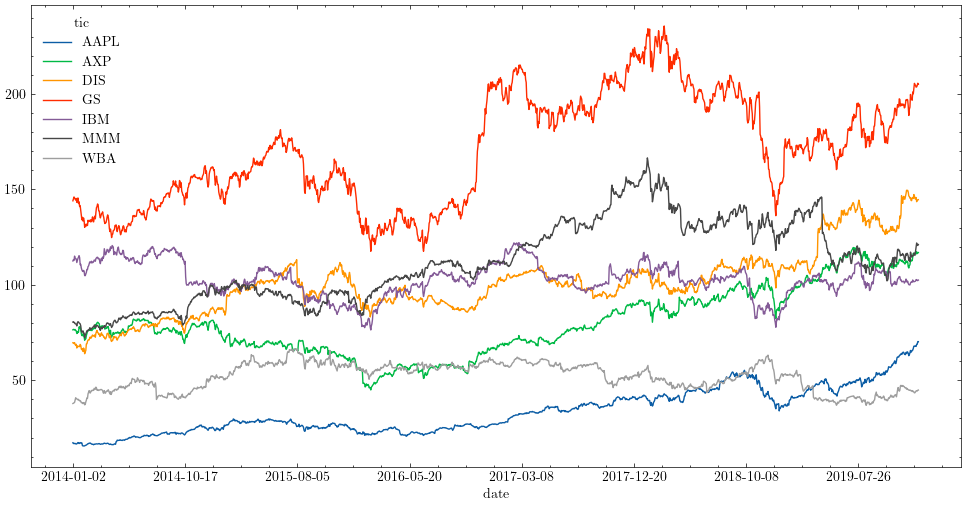

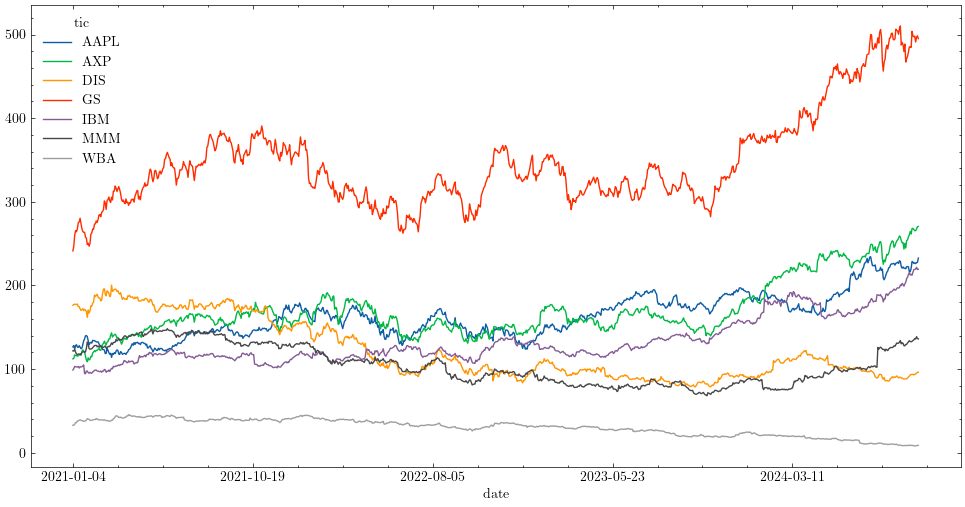

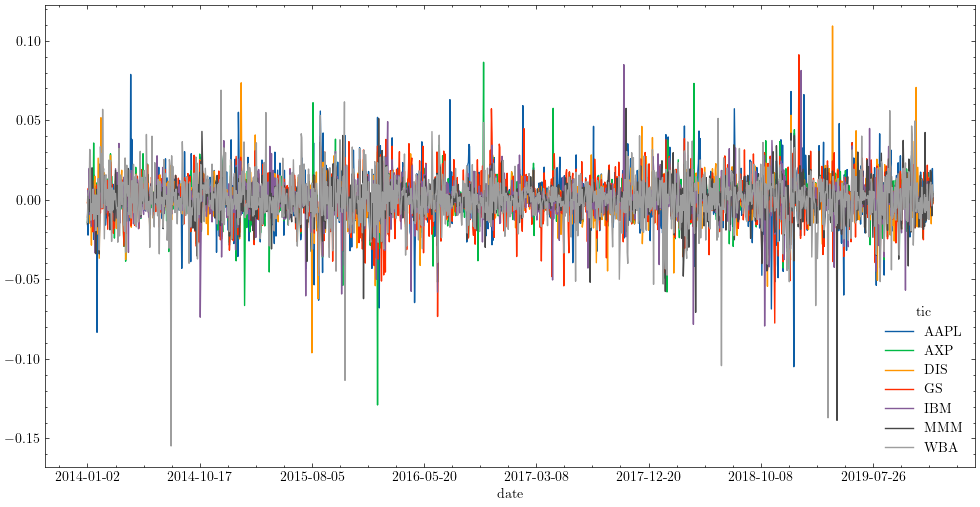

In [11]:
data = train_data
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(12,6))
    pv = test_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(12,6))
    pv = data.pivot(values='log_return',columns='tic',index='date')
    pv.plot(figsize=(12,6))

    

### PPO


![ppo](./screenshots/ppo.png)

assets : ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']

dates : TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

In [7]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema","close_62_ema"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dow30_chl',transaction_fee = 0.003,load=True,
                         model_path='./data/history_main_close.close_21_ema.close_62_ema_dow30_chl/best/best_model'
)

Initial portfolio value:250000
Final portfolio value: 334389.4375
Final accumulative portfolio value: 1.33755775
Maximum DrawDown: -0.21096650764847402
Sharpe ratio: 0.5976140495425616
hit end!


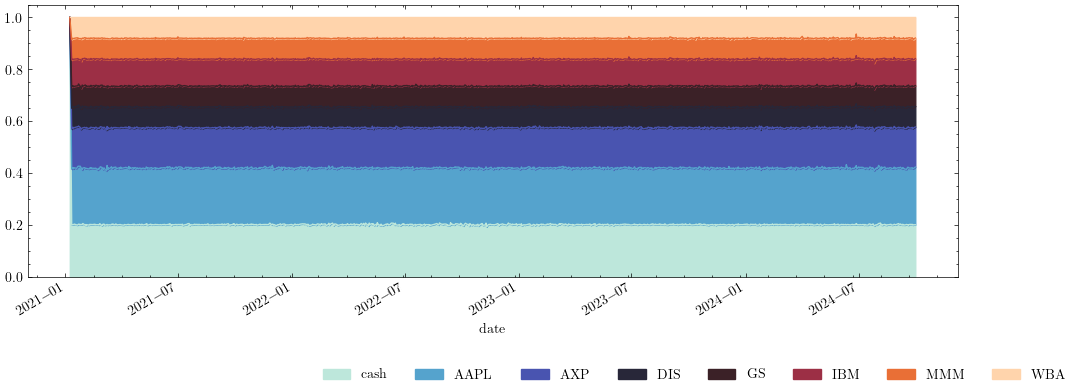

In [8]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns =['cash'] + columns
%matplotlib inline
with plt.style.context('science','ieee'):
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire").legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    # zz = result_ppo['test'][0]['daily_return']
    # zz.index=result_ppo['test'][0]['date']
    # print('max drowdown:', qs.stats.max_drawdown(result_ppo['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_ppo['test'][0].daily_return))
    # qs.plots.snapshot(zz)


Losts of usesless trades
acting similar to buy and hold but seems overfitted to training
does not seem to capture the trends meaningfully

### PPO SHARPE

![ppo](./screenshots/ppo_sharpe.png)

assets : ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']

dates : TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

In [23]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema","close_62_ema"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dow30_sharpe',sharpe_reward=True,transaction_fee = 0.003,
                         load=True,
                         model_path='./data/history_main_close.close_21_ema.close_62_ema_dow30_sharpe/ppo_150000_steps'
)

Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 295818.78125
Final accumulative portfolio value: 1.183275125
Maximum DrawDown: -0.23834806705511713
Sharpe ratio: 0.3766148064450469
hit end!


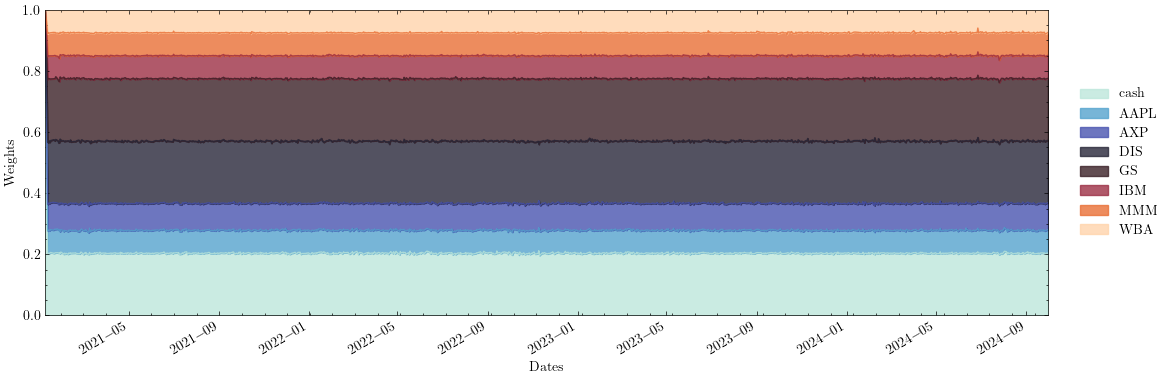

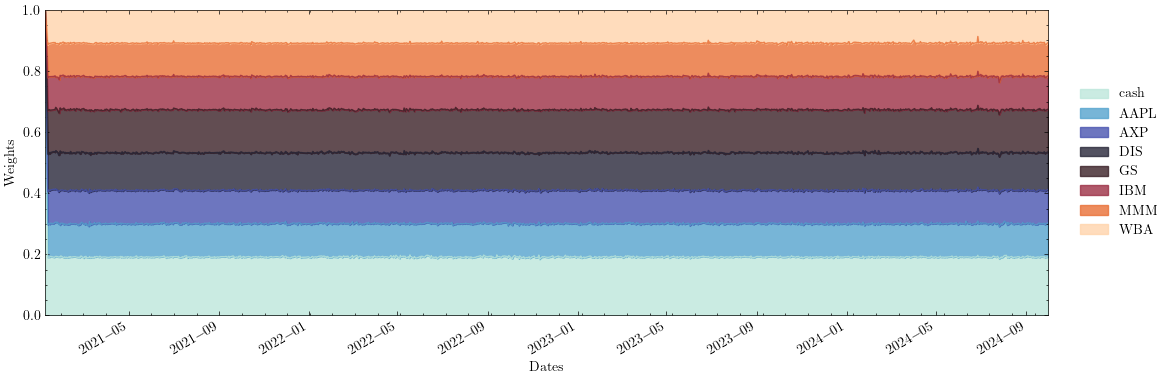

In [24]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()


## PPO without transaction cost

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema"]
                         ,iterations=iterations,model_name='ppo',tag='without_fee',transaction_fee = 0
                         ,comission_fee_model = None,
                        load=True,
                         model_path='./data/history_main_close.close_21_ema_without_fee/ppo_110000_steps')

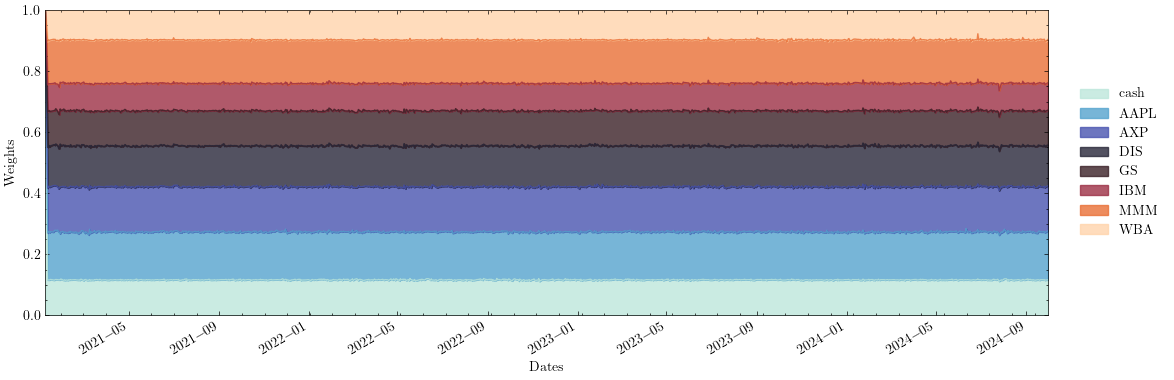

In [28]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()


## PPO high transaction cost

In [14]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee',transaction_fee = 0.01
                         ,comission_fee_model = "trf"
                         ,load=True,
                         model_path='./data/history_main_close.rsi.atr.macd_high_trading_fee/ppo_50000_steps')

Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 158677.34375
Final accumulative portfolio value: 0.634709375
Maximum DrawDown: -0.5036778742228485
Sharpe ratio: -0.6717403749762119
hit end!


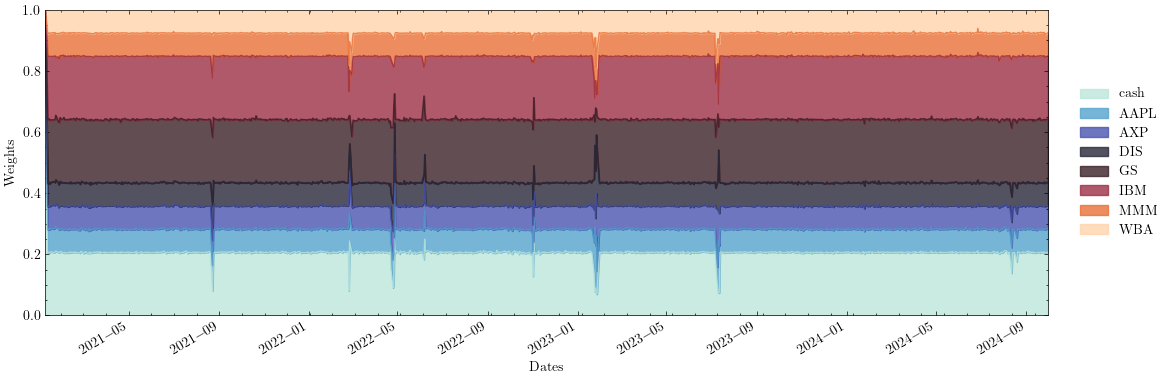

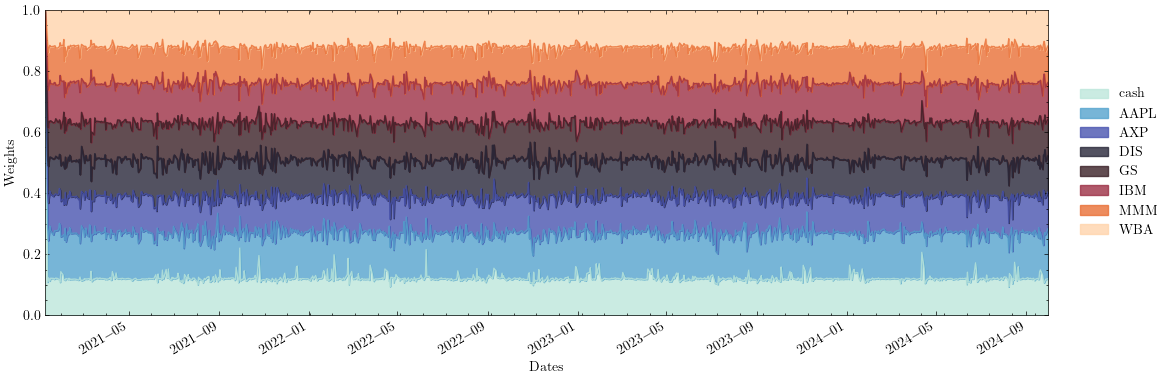

In [15]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

## MVO

In [7]:
from utils import mvo_data,mvo
correlation_data = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE)


In [12]:
min_variance_portfolio = mvo(correlation_data,pct=0.0001)

begin_total_asset:50000
end_total_asset:59172.915262656825
Sharpe:  0.3394930848644334
Test Finished!
episode_return 1.1834583052531364


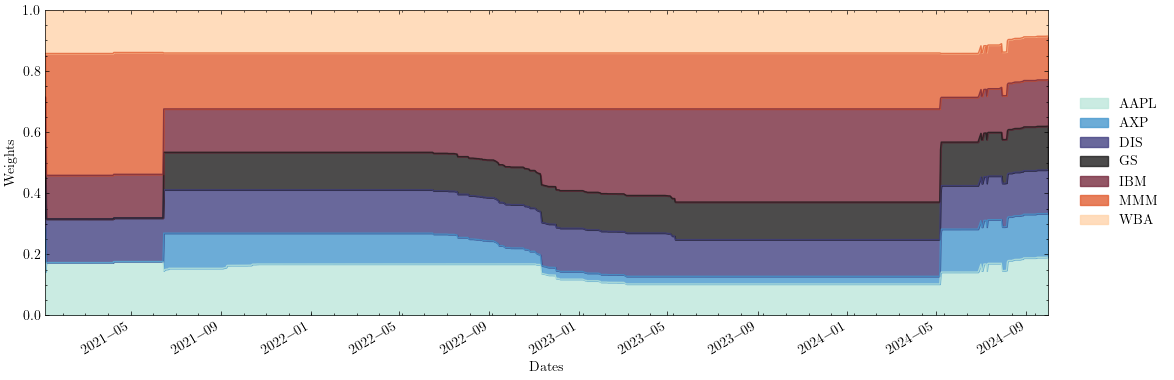

In [13]:
w = pd.DataFrame(min_variance_portfolio['action'])
unique_tics = test_data.tic.unique().tolist()
unique_tics.append('date')
w['date'] = min_variance_portfolio['date']
w.columns = unique_tics
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()
 


In [24]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee',transaction_fee = 0.005
                         ,comission_fee_model = "trf")


Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboardlog_close_rsi_atr_macd_high_trading_fee/ppo_6
Initial portfolio value:250000
Final portfolio value: 18538.318359375
Final accumulative portfolio value: 0.0741532734375
Maximum DrawDown: -0.9276402311885401
Sharpe ratio: -3.091269624435641
-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 1.5e+03      |
|    ep_rew_mean     | -2.6         |
| time/              |              |
|    fps             | 90           |
|    iterations      | 1            |
|    time_elapsed    | 22           |
|    total_timesteps | 2048         |
| train/             |      

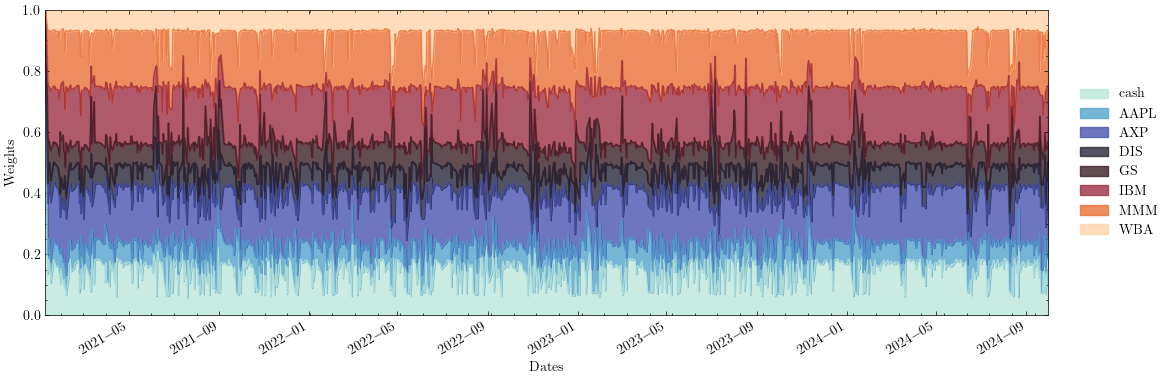

In [25]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

In [26]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "trf")


Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboardlog_close_rsi_atr_macd_high_trading_fee_0.01/ppo_1
Initial portfolio value:250000
Final portfolio value: 959.8309326171875
Final accumulative portfolio value: 0.00383932373046875
Maximum DrawDown: -0.996172845703125
Sharpe ratio: -6.808694538540017
--------------------------------------
| rollout/           |               |
|    ep_len_mean     | 1.5e+03       |
|    ep_rew_mean     | -5.57         |
| time/              |               |
|    fps             | 92            |
|    iterations      | 1             |
|    time_elapsed    | 22            |
|    total_timesteps | 2048          |
| train/ 

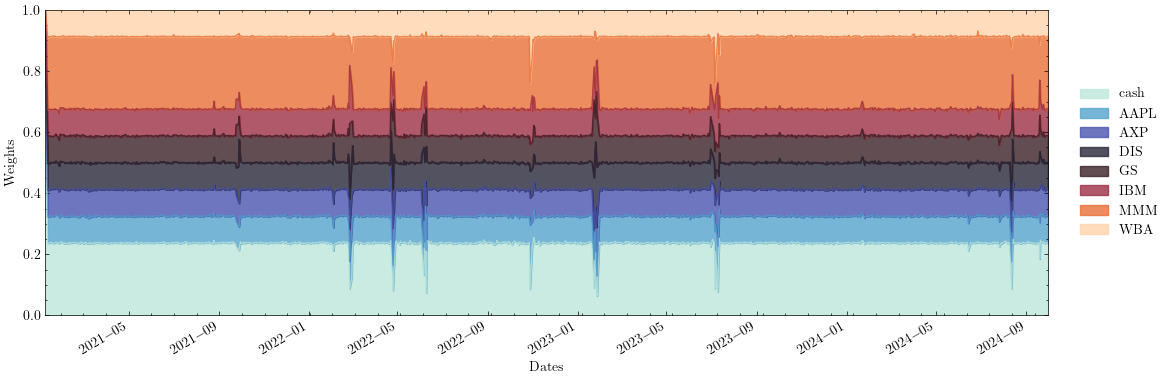

In [27]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

In [28]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.005
                         ,comission_fee_model = "trf")


Normalizing ['close'] by previous time...
Normalizing ['close'] by previous time...
Normalizing ['close'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboardlog_close_high_trading_fee_0.01/ppo_1
Initial portfolio value:250000
Final portfolio value: 20645.64453125
Final accumulative portfolio value: 0.082582578125
Maximum DrawDown: -0.918085109375
Sharpe ratio: -3.0309048243398897
--------------------------------------
| rollout/           |               |
|    ep_len_mean     | 1.5e+03       |
|    ep_rew_mean     | -2.49         |
| time/              |               |
|    fps             | 100           |
|    iterations      | 1             |
|    time_elapsed    | 20            |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0071266317 |
--------------------

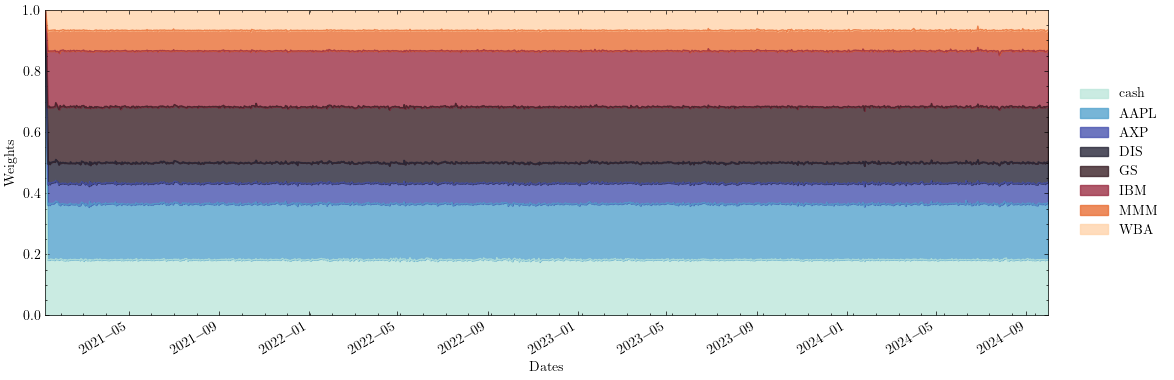

In [30]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()